In [4]:
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import sys
#%matplotlib inline

from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Conv2DTranspose, LeakyReLU, BatchNormalization, Activation
from keras.models import Model
from keras import losses, regularizers, constraints
from keras import backend as K
from keras import metrics

from vis.visualization import visualize_activation, visualize_activation_with_losses
from vis.regularizers import TotalVariation, LPNorm
from vis.losses import ActivationMaximization
from vis.input_modifiers import Jitter
                                                                   
import h5py
import importlib

sys.path.append('/home/bastien/Documents/StageCMM/Auto-encoders/SourceCode')
from sparseShallowAE import SparseShallowAE_KL, SparseShallowAE_L1, SparseShallowAE_KL_sum
from nonNegSparseShallowAE import *
import bastien_utils
import custom_regularizers

In [2]:
FILE_PATH = "../"
data = bastien_utils.load_data(FILE_PATH, train=True, test=True, subsetTest=True)
x_train, ytrain, x_test, y_test, x_small, y_small = data
print('x_small shape:', x_small.shape)
print('x_test shape:', x_test.shape)

x_small shape: (10, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)


# 0. Models without non-negativity constraint

# 1. Keras Non-negativity constraint

Keras non_neg() constraint simply sets to zero all negative weights from the layer, before computing the output of the feedforward step.

## 1.2 Simple

In [19]:
latent_dim = 100


input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format
x = Flatten()(input_img)

encoded = Dense(latent_dim, activation='sigmoid', kernel_constraint=constraints.non_neg())(x)

encoder = Model(input_img, encoded, name='encoder')
encoder.summary()

encoded_img = Input(shape=(latent_dim,))  # adapt this if using `channels_first` image data format

x = Dense(28*28)(encoded_img)
x = LeakyReLU(alpha=0.1)(x)
decoded = Reshape((28,28,1))(x)

decoder = Model(encoded_img, decoded, name='decoder')
decoder.summary()

encoded = encoder(input_img)
decoded = decoder(encoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
Total params: 78,500
Trainable params: 78,500
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 784)               79184     
_________________________________________________________________
leaky_

In [23]:
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                )

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 8s 137us/step - loss: 0.0887 - val_loss: 0.0816
Epoch 2/100
60000/60000 [==============================] - 7s 109us/step - loss: 0.0806 - val_loss: 0.0784
Epoch 3/100
60000/60000 [==============================] - 6s 107us/step - loss: 0.0747 - val_loss: 0.0696
Epoch 4/100
60000/60000 [==============================] - 7s 118us/step - loss: 0.0645 - val_loss: 0.0591
Epoch 5/100
60000/60000 [==============================] - 8s 141us/step - loss: 0.0553 - val_loss: 0.0517
Epoch 6/100
60000/60000 [==============================] - 7s 110us/step - loss: 0.0499 - val_loss: 0.0481
Epoch 7/100
60000/60000 [==============================] - 6s 103us/step - loss: 0.0471 - val_loss: 0.0460
Epoch 8/100
60000/60000 [==============================] - 7s 113us/step - loss: 0.0453 - val_loss: 0.0443
Epoch 9/100
60000/60000 [==============================] - 6s 100us/step - loss: 0.0437 - val_

Epoch 77/100
60000/60000 [==============================] - 6s 107us/step - loss: 0.0188 - val_loss: 0.0188
Epoch 78/100
60000/60000 [==============================] - 6s 97us/step - loss: 0.0187 - val_loss: 0.0187
Epoch 79/100
60000/60000 [==============================] - 6s 98us/step - loss: 0.0186 - val_loss: 0.0186
Epoch 80/100
60000/60000 [==============================] - 6s 96us/step - loss: 0.0185 - val_loss: 0.0185
Epoch 81/100
60000/60000 [==============================] - 6s 94us/step - loss: 0.0185 - val_loss: 0.0185
Epoch 82/100
60000/60000 [==============================] - 6s 101us/step - loss: 0.0184 - val_loss: 0.0184
Epoch 83/100
60000/60000 [==============================] - 6s 97us/step - loss: 0.0183 - val_loss: 0.0183
Epoch 84/100
60000/60000 [==============================] - 7s 121us/step - loss: 0.0182 - val_loss: 0.0182
Epoch 85/100
60000/60000 [==============================] - 6s 102us/step - loss: 0.0182 - val_loss: 0.0182
Epoch 86/100
60000/60000 [=======

`
dir_models='../ShallowAE/Simple/NonNeg/Models/'
model_path= dir_models + 'dim100_NonNegConstraint.h5'
autoencoder.save(model_path)
`

In [27]:
dir_models='../ShallowAE/Simple/NonNeg/Models/'
model_path= dir_models + 'dim100_NonNegConstraint.h5'
autoencoder, encoder, decoder = bastien_utils.load_AE(model_path)

In [32]:
encoder.get_config()['layers'][2]['config']

{'activation': 'sigmoid',
 'activity_regularizer': None,
 'bias_constraint': None,
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'bias_regularizer': None,
 'kernel_constraint': {'class_name': 'NonNeg', 'config': {}},
 'kernel_initializer': {'class_name': 'VarianceScaling',
  'config': {'distribution': 'uniform',
   'mode': 'fan_avg',
   'scale': 1.0,
   'seed': None}},
 'kernel_regularizer': None,
 'name': 'dense_1',
 'trainable': True,
 'units': 100,
 'use_bias': True}

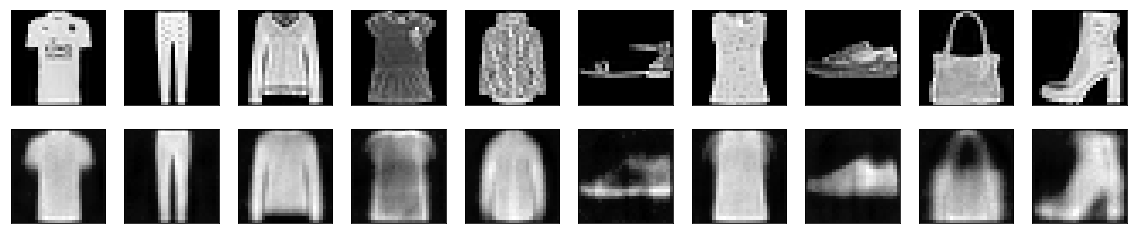

In [27]:
bastien_utils.plot_reconstructions(autoencoder, x_small)

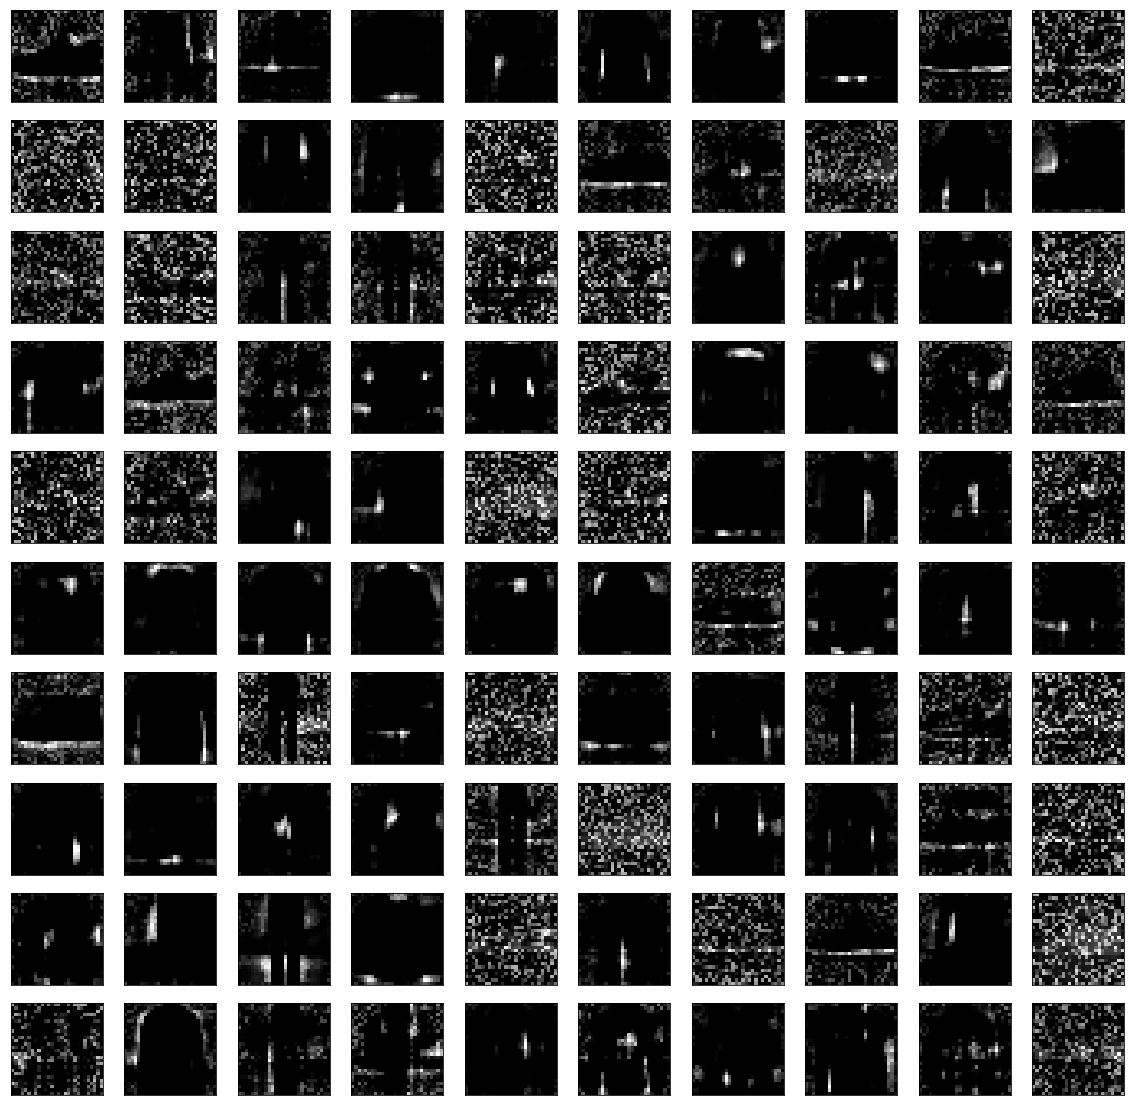

In [28]:
bastien_utils.plot_atoms(encoder)

## 1.2 Sparsity constraint

In [29]:
latent_dim = 100


input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format
x = Flatten()(input_img)

encoded = Dense(latent_dim, activation='sigmoid', activity_regularizer=custom_regularizers.KL_divergence(), kernel_constraint=constraints.non_neg())(x)

encoder = Model(input_img, encoded, name='encoder')
encoder.summary()

encoded_img = Input(shape=(latent_dim,))  # adapt this if using `channels_first` image data format

x = Dense(28*28)(encoded_img)
x = LeakyReLU(alpha=0.1)(x)
decoded = Reshape((28,28,1))(x)

decoder = Model(encoded_img, decoded, name='decoder')
decoder.summary()

encoded = encoder(input_img)
decoded = decoder(encoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
autoencoder.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               78500     
Total params: 78,500
Trainable params: 78,500
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 784)               79184     
_________________________________________________________________
leaky_

In [30]:
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                )

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 7s 118us/step - loss: 0.4395 - val_loss: 0.2648
Epoch 2/100
60000/60000 [==============================] - 7s 117us/step - loss: 0.1975 - val_loss: 0.1440
Epoch 3/100
60000/60000 [==============================] - 7s 115us/step - loss: 0.1103 - val_loss: 0.0797
Epoch 4/100
60000/60000 [==============================] - 10s 171us/step - loss: 0.0655 - val_loss: 0.0599
Epoch 5/100
60000/60000 [==============================] - 7s 121us/step - loss: 0.0530 - val_loss: 0.0513
Epoch 6/100
60000/60000 [==============================] - 6s 98us/step - loss: 0.0488 - val_loss: 0.0454
Epoch 7/100
60000/60000 [==============================] - 6s 96us/step - loss: 0.0428 - val_loss: 0.0405
Epoch 8/100
60000/60000 [==============================] - 6s 98us/step - loss: 0.0382 - val_loss: 0.0367
Epoch 9/100
60000/60000 [==============================] - 6s 96us/step - loss: 0.0350 - val_los

In [31]:
dir_models='../ShallowAE/Sparse/NonNeg/Models/'
model_path= dir_models + 'dim100_NonNegConstraint.h5'
autoencoder.save(model_path)

In [24]:
dir_models='../ShallowAE/Sparse/NonNeg/Models/'
model_path= dir_models + 'dim100_NonNegConstraint.h5'
autoencoder, encoder, decoder = bastien_utils.load_AE(model_path, custom_objects={'KL_divergence':custom_regularizers.KL_divergence})

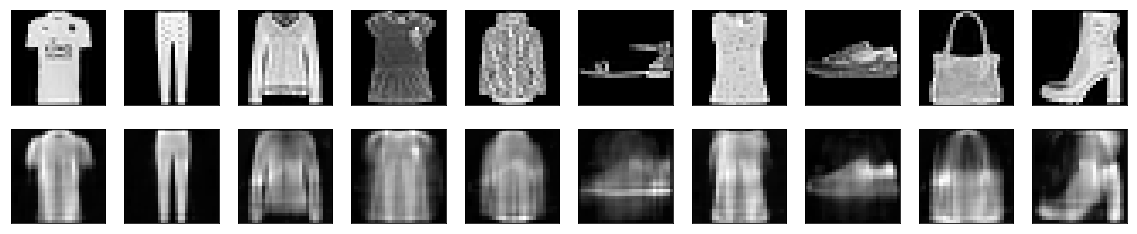

In [25]:
bastien_utils.plot_reconstructions(autoencoder, x_small)

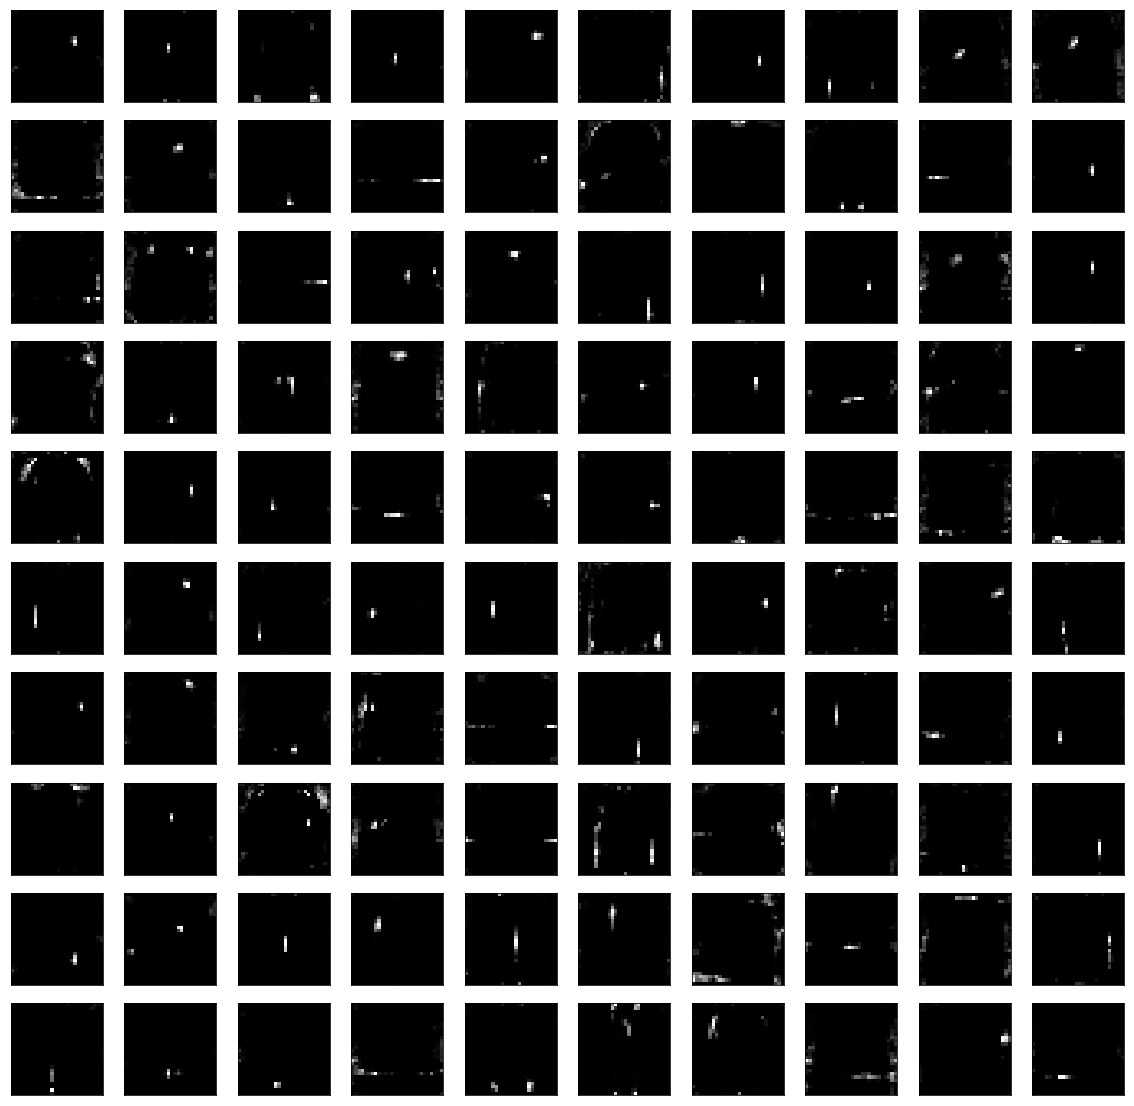

In [5]:
bastien_utils.plot_atoms(encoder)

# 2.Asymetric Weight Decay

In [3]:
from keras.regularizers import Regularizer
from keras import backend as K

class asymmetric_weight_decay(Regularizer):
    """Asymmetric weight decay for Non_Negativity constraint.
    # Arguments
        alpha: Float; Weight decay parameter for the positive weights.
        beta: Float; Weight decay parameter for the negative weights.
        lam: Float; Weight of the whole regularizer loss.
    """

    def __init__(self, alpha=0.1, beta=1, lam=0.1):
        self.alpha = K.cast_to_floatx(alpha)
        self.beta = K.cast_to_floatx(beta)
        self.lam = K.cast_to_floatx(lam/2)

    def __call__(self, x):
        sh = K.shape(x)
        neg = K.cast(K.less(x, K.zeros(sh)), 'float32')
        pos = K.cast(K.less(K.zeros(sh), x), 'float32')
        sq = K.square(x)
        val = K.sum(self.beta*neg*sq + self.alpha*pos*sq)
        return self.lam*val

    def get_config(self):
        return {'alpha': float(self.alpha),
                'beta': float(self.beta),
                'lam': float(self.lam)}

    

## 2.1 Simple

In [14]:
latent_dim = 100


input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format
x = Flatten()(input_img)

encoded = Dense(latent_dim, activation='sigmoid', kernel_regularizer=asymmetric_weight_decay())(x)

encoder = Model(input_img, encoded, name='encoder')
encoder.summary()

encoded_img = Input(shape=(latent_dim,))  # adapt this if using `channels_first` image data format

x = Dense(28*28)(encoded_img)
x = LeakyReLU(alpha=0.1)(x)
decoded = Reshape((28,28,1))(x)

decoder = Model(encoded_img, decoded, name='decoder')
decoder.summary()

encoded = encoder(input_img)
decoded = decoder(encoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               78500     
Total params: 78,500
Trainable params: 78,500
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 784)               79184     
_________________________________________________________________
leaky_

In [15]:
autoencoder.fit(x_train, x_train,
                epochs=200,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                )

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 7s 121us/step - loss: 0.3205 - val_loss: 0.0769
Epoch 2/200
60000/60000 [==============================] - 7s 112us/step - loss: 0.0737 - val_loss: 0.0697
Epoch 3/200
60000/60000 [==============================] - 7s 123us/step - loss: 0.0671 - val_loss: 0.0641
Epoch 4/200
60000/60000 [==============================] - 7s 113us/step - loss: 0.0623 - val_loss: 0.0601
Epoch 5/200
60000/60000 [==============================] - 7s 118us/step - loss: 0.0587 - val_loss: 0.0570
Epoch 6/200
60000/60000 [==============================] - 7s 111us/step - loss: 0.0560 - val_loss: 0.0546
Epoch 7/200
60000/60000 [==============================] - 6s 99us/step - loss: 0.0539 - val_loss: 0.0528
Epoch 8/200
60000/60000 [==============================] - 6s 93us/step - loss: 0.0524 - val_loss: 0.0515
Epoch 9/200
60000/60000 [==============================] - 6s 94us/step - loss: 0.0512 - val_los

Epoch 77/200
60000/60000 [==============================] - 7s 120us/step - loss: 0.0361 - val_loss: 0.0382
Epoch 78/200
60000/60000 [==============================] - 6s 104us/step - loss: 0.0361 - val_loss: 0.0368
Epoch 79/200
60000/60000 [==============================] - 7s 118us/step - loss: 0.0361 - val_loss: 0.0360
Epoch 80/200
60000/60000 [==============================] - 6s 101us/step - loss: 0.0359 - val_loss: 0.0354
Epoch 81/200
60000/60000 [==============================] - 6s 95us/step - loss: 0.0359 - val_loss: 0.0353
Epoch 82/200
60000/60000 [==============================] - 6s 102us/step - loss: 0.0358 - val_loss: 0.0366
Epoch 83/200
60000/60000 [==============================] - 6s 101us/step - loss: 0.0358 - val_loss: 0.0350
Epoch 84/200
60000/60000 [==============================] - 6s 98us/step - loss: 0.0357 - val_loss: 0.0355
Epoch 85/200
60000/60000 [==============================] - 6s 99us/step - loss: 0.0358 - val_loss: 0.0350
Epoch 86/200
60000/60000 [=====

In [16]:
dir_models='../ShallowAE/Simple/NonNeg/Models/'
model_path= dir_models + 'dim100_NonNegRegularizer.h5'
autoencoder.save(model_path)

In [ ]:
dir_models='../ShallowAE/Simple/NonNeg/Models/'
model_path= dir_models + 'dim100_NonNegRegularizer.h5'
autoencoder, encoder, decoder = bastien_utils.load_AE(model_path, custom_objects={'asymmetric_weight_decay':asymmetric_weight_decay})

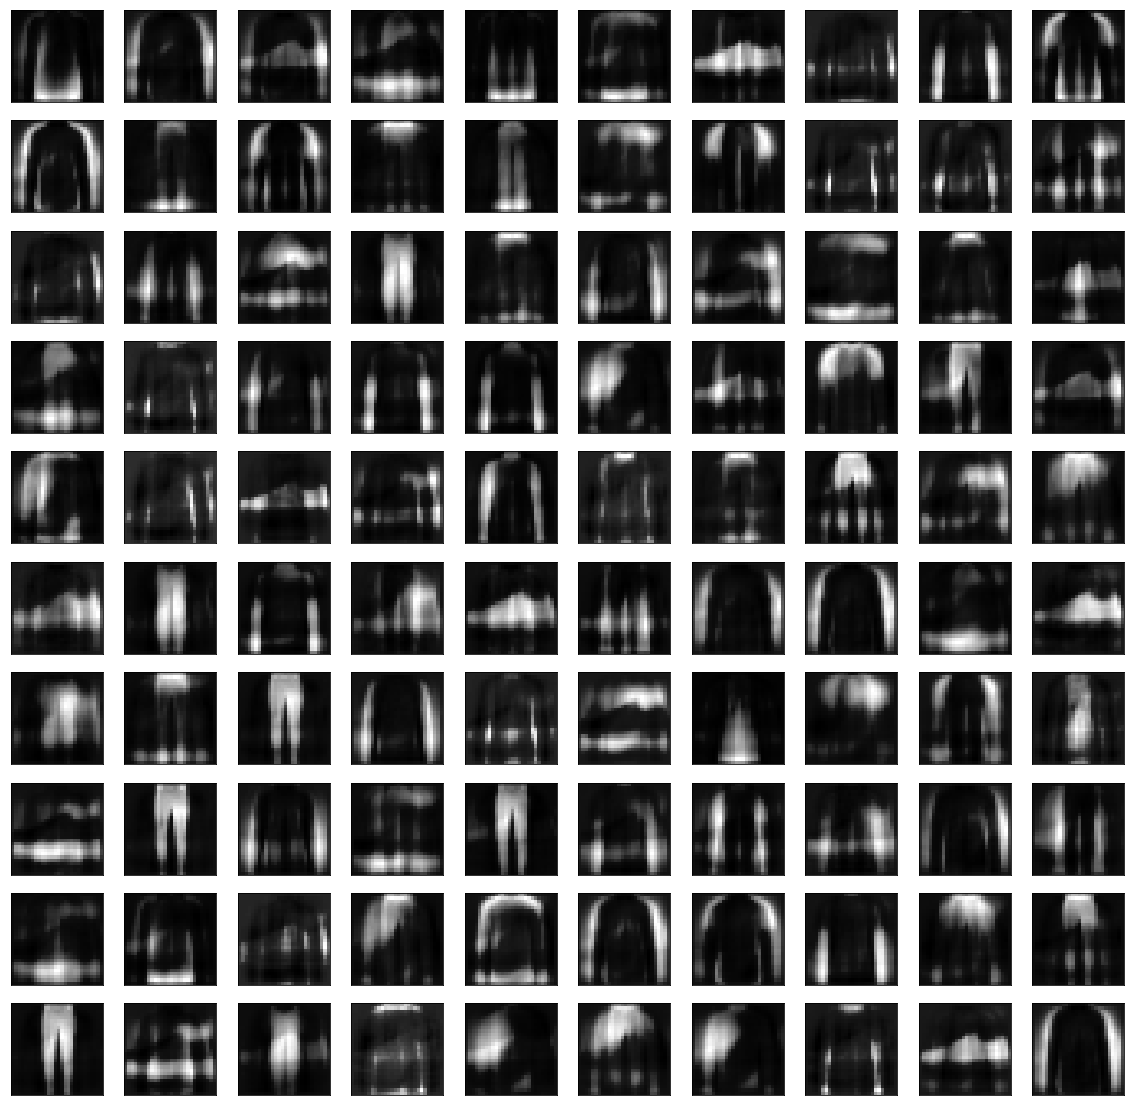

In [17]:
bastien_utils.plot_atoms(encoder)

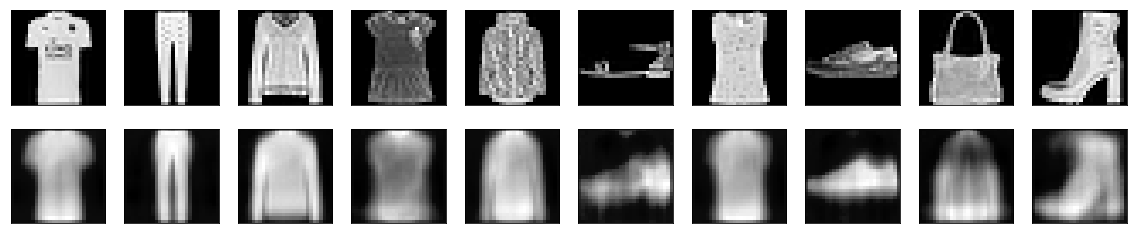

In [23]:
bastien_utils.plot_reconstructions(autoencoder, x_small)

In [22]:
importlib.reload(bastien_utils)

<module 'bastien_utils' from '/home/bastien/Documents/StageCMM/Auto-encoders/SourceCode/bastien_utils.py'>

## 2.2 Sparse

In [4]:
latent_dim = 100


input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format
x = Flatten()(input_img)

encoded = Dense(latent_dim, activation='sigmoid', activity_regularizer=custom_regularizers.KL_divergence(), kernel_regularizer=asymmetric_weight_decay(alpha=0, beta=1, lam=1))(x)

encoder = Model(input_img, encoded, name='encoder')
encoder.summary()

encoded_img = Input(shape=(latent_dim,))  # adapt this if using `channels_first` image data format

x = Dense(28*28)(encoded_img)
x = LeakyReLU(alpha=0.1)(x)
decoded = Reshape((28,28,1))(x)

decoder = Model(encoded_img, decoded, name='decoder')
decoder.summary()

encoded = encoder(input_img)
decoded = decoder(encoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
Total params: 78,500
Trainable params: 78,500
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 784)               79184     
_________________________________________________________________
leaky_

In [5]:
autoencoder.fit(x_train, x_train,
                epochs=200,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                )

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
37760/60000 [=================>............] - ETA: 3s - loss: 3.2806

KeyboardInterrupt: 

In [30]:
dir_models='../ShallowAE/Sparse/NonNeg/Models/'
model_path= dir_models + 'dim100_NonNegRegularizer.h5'
autoencoder.save(model_path)

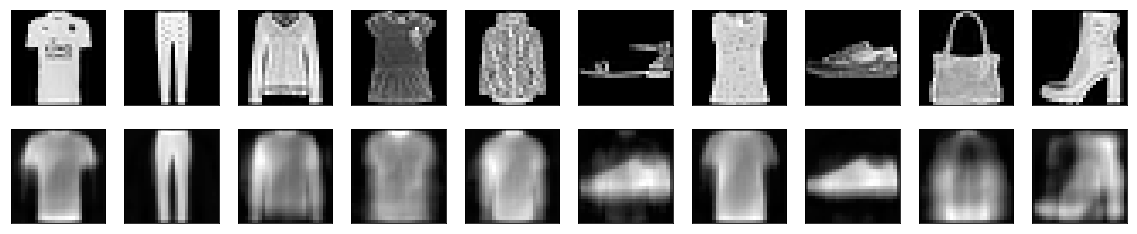

In [31]:
bastien_utils.plot_reconstructions(autoencoder, x_small)

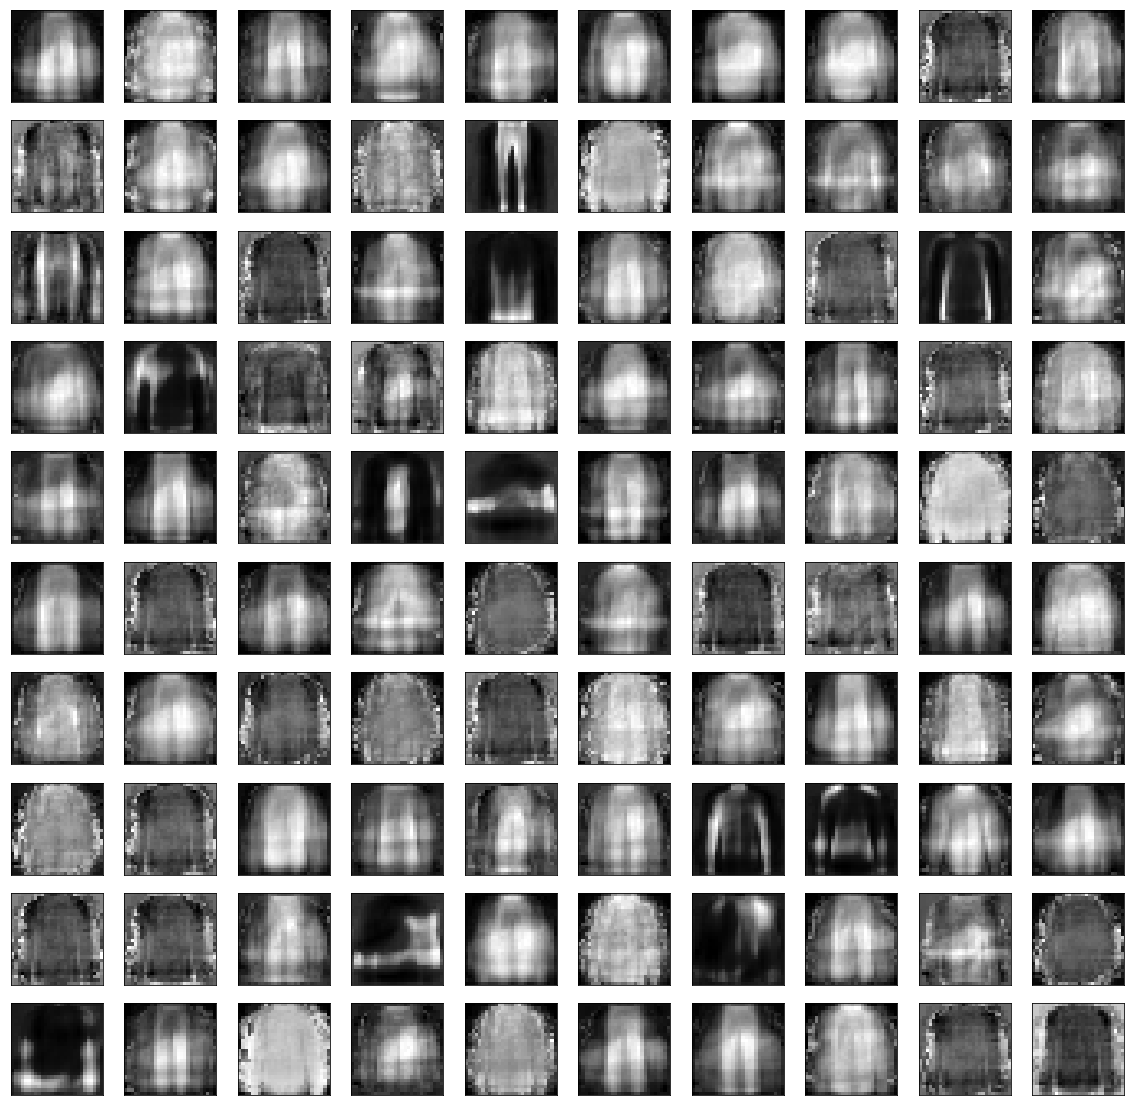

In [32]:
bastien_utils.plot_atoms(encoder)

### 2.2.2 Alpha = 0, Beta = 1, Lambda = 1

In [6]:
latent_dim = 100


input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format
x = Flatten()(input_img)

encoded = Dense(latent_dim, activation='sigmoid', activity_regularizer=custom_regularizers.KL_divergence(), kernel_regularizer=asymmetric_weight_decay(alpha=0, beta=1, lam=1))(x)

encoder = Model(input_img, encoded, name='encoder')
encoder.summary()

encoded_img = Input(shape=(latent_dim,))  # adapt this if using `channels_first` image data format

x = Dense(28*28)(encoded_img)
x = LeakyReLU(alpha=0.1)(x)
decoded = Reshape((28,28,1))(x)

decoder = Model(encoded_img, decoded, name='decoder')
decoder.summary()

encoded = encoder(input_img)
decoded = decoder(encoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               78500     
Total params: 78,500
Trainable params: 78,500
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 784)               79184     
_________________________________________________________________
leaky_

In [7]:
autoencoder.fit(x_train, x_train,
                epochs=200,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                )

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 9s 147us/step - loss: 2.1760 - val_loss: 0.2582
Epoch 2/200
60000/60000 [==============================] - 8s 134us/step - loss: 0.1799 - val_loss: 0.1225
Epoch 3/200
60000/60000 [==============================] - 8s 133us/step - loss: 0.0913 - val_loss: 0.0675
Epoch 4/200
60000/60000 [==============================] - 8s 134us/step - loss: 0.0617 - val_loss: 0.0548
Epoch 5/200
60000/60000 [==============================] - 8s 131us/step - loss: 0.0503 - val_loss: 0.0452
Epoch 6/200
60000/60000 [==============================] - 10s 164us/step - loss: 0.0414 - val_loss: 0.0378
Epoch 7/200
60000/60000 [==============================] - 8s 131us/step - loss: 0.0354 - val_loss: 0.0313
Epoch 8/200
60000/60000 [==============================] - 8s 134us/step - loss: 0.0324 - val_loss: 0.0291
Epoch 9/200
60000/60000 [==============================] - 9s 145us/step - loss: 0.0302 - val

60000/60000 [==============================] - 8s 131us/step - loss: 0.0179 - val_loss: 0.0144
Epoch 152/200
60000/60000 [==============================] - 8s 130us/step - loss: 0.0175 - val_loss: 0.0171
Epoch 153/200
60000/60000 [==============================] - 8s 127us/step - loss: 0.0179 - val_loss: 0.0163
Epoch 154/200
60000/60000 [==============================] - 8s 127us/step - loss: 0.0176 - val_loss: 0.0144
Epoch 155/200
60000/60000 [==============================] - 9s 149us/step - loss: 0.0175 - val_loss: 0.0189
Epoch 156/200
60000/60000 [==============================] - 10s 168us/step - loss: 0.0178 - val_loss: 0.0209
Epoch 157/200
60000/60000 [==============================] - 10s 173us/step - loss: 0.0175 - val_loss: 0.0161
Epoch 158/200
60000/60000 [==============================] - 9s 154us/step - loss: 0.0171 - val_loss: 0.0158
Epoch 159/200
60000/60000 [==============================] - 9s 155us/step - loss: 0.0177 - val_loss: 0.0396
Epoch 160/200
60000/60000 [====

In [8]:
dir_models='../ShallowAE/Sparse/NonNeg/Models/'
model_path= dir_models + 'dim100_NonNegRegularizer_0_1_1.h5'
autoencoder.save(model_path)

In [13]:
np.median(autoencoder.evaluate(x_test, x_test))

10000/10000 [==============================] - 1s 76us/step


0.026376612

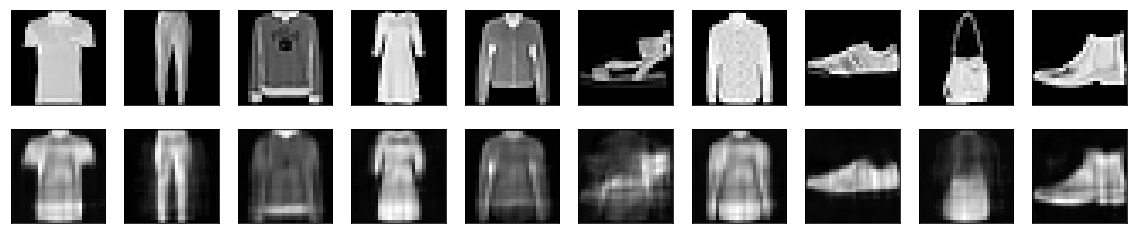

In [9]:
bastien_utils.plot_reconstructions(autoencoder, x_small)

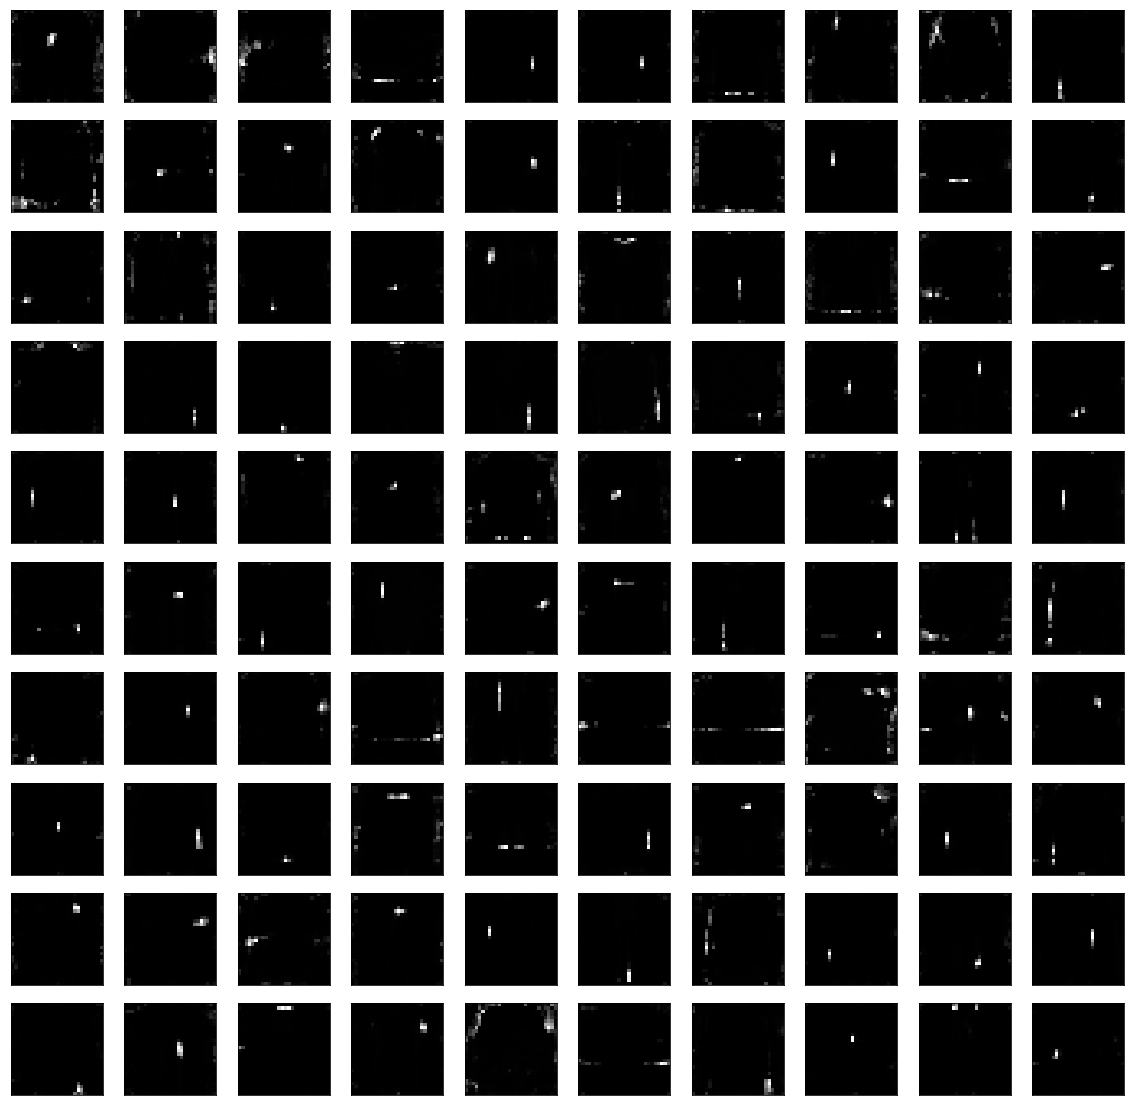

In [10]:
bastien_utils.plot_atoms(encoder)

### 2.2.3 Dimension 10 with the same settings

In [14]:
latent_dim = 10


input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format
x = Flatten()(input_img)

encoded = Dense(latent_dim, activation='sigmoid', activity_regularizer=custom_regularizers.KL_divergence(), kernel_regularizer=asymmetric_weight_decay(alpha=0, beta=1, lam=1))(x)

encoder = Model(input_img, encoded, name='encoder')
encoder.summary()

encoded_img = Input(shape=(latent_dim,))  # adapt this if using `channels_first` image data format

x = Dense(28*28)(encoded_img)
x = LeakyReLU(alpha=0.1)(x)
decoded = Reshape((28,28,1))(x)

decoder = Model(encoded_img, decoded, name='decoder')
decoder.summary()

encoded = encoder(input_img)
decoded = decoder(encoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 784)               8624      
_________________________________________________________________
leaky_re

In [16]:
autoencoder.fit(x_train, x_train,
                epochs=150,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                )

Train on 60000 samples, validate on 10000 samples
Epoch 1/150
60000/60000 [==============================] - 5s 85us/step - loss: 0.1837 - val_loss: 0.1589
Epoch 2/150
60000/60000 [==============================] - 5s 76us/step - loss: 0.1408 - val_loss: 0.1203
Epoch 3/150
60000/60000 [==============================] - 4s 73us/step - loss: 0.1173 - val_loss: 0.1083
Epoch 4/150
60000/60000 [==============================] - 4s 72us/step - loss: 0.1029 - val_loss: 0.0960
Epoch 5/150
60000/60000 [==============================] - 5s 78us/step - loss: 0.0954 - val_loss: 0.0877
Epoch 6/150
60000/60000 [==============================] - 4s 72us/step - loss: 0.0922 - val_loss: 0.0887
Epoch 7/150
60000/60000 [==============================] - 4s 70us/step - loss: 0.0865 - val_loss: 0.0826
Epoch 8/150
60000/60000 [==============================] - 4s 73us/step - loss: 0.0799 - val_loss: 0.0787
Epoch 9/150
60000/60000 [==============================] - 4s 73us/step - loss: 0.0773 - val_loss: 0.0

In [17]:
dir_models='../ShallowAE/Sparse/NonNeg/Models/'
model_path= dir_models + 'dim10_NonNegRegularizer_0_1_1.h5'
autoencoder.save(model_path)

In [22]:
np.median(autoencoder.evaluate(x_test, x_test))

10000/10000 [==============================] - 0s 41us/step


0.03374078

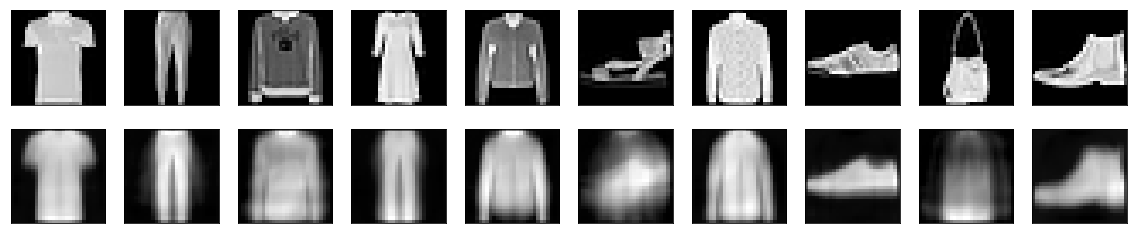

In [19]:
bastien_utils.plot_reconstructions(autoencoder, x_small)

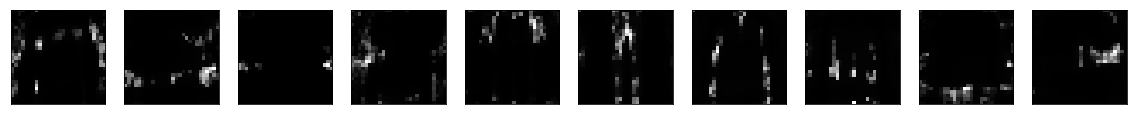

In [20]:
bastien_utils.plot_atoms(encoder)

In [33]:
dir_models='../ShallowAE/Sparse/NonNeg/Models/'
model_path= dir_models + 'dim10_NonNegRegularizer_0_1_1.h5'
autoencoder, encoder, decoder = bastien_utils.load_AE(model_path, custom_objects={'KL_divergence':custom_regularizers.KL_divergence, 'asymmetric_weight_decay':custom_regularizers.asymmetric_weight_decay})

In [36]:
autoencoder.evaluate(x_test, x_test)

10000/10000 [==============================] - 2s 210us/step


array([0.03379975, 0.03353949, 0.03522294, 0.03400273, 0.03321102,
       0.03432087, 0.03393234, 0.03225022, 0.03360397, 0.03242281],
      dtype=float32)

In [7]:
W = bastien_utils.atom_images(encoder)

In [23]:
np.sum(W<-0.001)/np.prod(W.shape)*100

1.403061224489796

### 2.2.3 KL_div_sum and non negativity 

In [7]:
latent_dim = 100


input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format
x = Flatten()(input_img)

encoded = Dense(latent_dim, activation='sigmoid', activity_regularizer=custom_regularizers.KL_divergence_sum(beta=0.1, rho=0.1), kernel_regularizer=custom_regularizers.asymmetric_weight_decay(alpha=0, beta=1, lam=1))(x)

encoder = Model(input_img, encoded, name='encoder')
encoder.summary()

encoded_img = Input(shape=(latent_dim,))  # adapt this if using `channels_first` image data format

x = Dense(28*28)(encoded_img)
x = LeakyReLU(alpha=0.1)(x)
decoded = Reshape((28,28,1))(x)

decoder = Model(encoded_img, decoded, name='decoder')
decoder.summary()

encoded = encoder(input_img)
decoded = decoder(encoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
Total params: 78,500
Trainable params: 78,500
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 784)               79184     
_________________________________________________________________
leaky_

In [8]:
autoencoder.fit(x_train, x_train,
                epochs=200,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                )


Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 19s 309us/step - loss: 3.2352 - val_loss: 0.9830
Epoch 2/200
60000/60000 [==============================] - 14s 232us/step - loss: 0.6690 - val_loss: 0.4221
Epoch 3/200
60000/60000 [==============================] - 15s 243us/step - loss: 0.2686 - val_loss: 0.1584
Epoch 4/200
60000/60000 [==============================] - 16s 265us/step - loss: 0.1136 - val_loss: 0.0903
Epoch 5/200
60000/60000 [==============================] - 16s 270us/step - loss: 0.0876 - val_loss: 0.0857
Epoch 6/200
60000/60000 [==============================] - 14s 231us/step - loss: 0.0850 - val_loss: 0.0835
Epoch 7/200
60000/60000 [==============================] - 15s 242us/step - loss: 0.0829 - val_loss: 0.0813
Epoch 8/200
60000/60000 [==============================] - 14s 237us/step - loss: 0.0805 - val_loss: 0.0792
Epoch 9/200
60000/60000 [==============================] - 14s 229us/step - loss: 0.07

60000/60000 [==============================] - 18s 295us/step - loss: 0.0327 - val_loss: 0.0378
Epoch 76/200
60000/60000 [==============================] - 18s 293us/step - loss: 0.0328 - val_loss: 0.0320
Epoch 77/200
60000/60000 [==============================] - 17s 291us/step - loss: 0.0324 - val_loss: 0.0404
Epoch 78/200
60000/60000 [==============================] - 17s 288us/step - loss: 0.0325 - val_loss: 0.0408
Epoch 79/200
60000/60000 [==============================] - 17s 287us/step - loss: 0.0326 - val_loss: 0.0328
Epoch 80/200
60000/60000 [==============================] - 18s 295us/step - loss: 0.0324 - val_loss: 0.0328
Epoch 81/200
60000/60000 [==============================] - 17s 287us/step - loss: 0.0325 - val_loss: 0.0340
Epoch 82/200
60000/60000 [==============================] - 18s 293us/step - loss: 0.0326 - val_loss: 0.0346
Epoch 83/200
60000/60000 [==============================] - 18s 299us/step - loss: 0.0322 - val_loss: 0.0325
Epoch 84/200
60000/60000 [======

Epoch 150/200
60000/60000 [==============================] - 19s 315us/step - loss: 0.0286 - val_loss: 0.0336
Epoch 151/200
60000/60000 [==============================] - 18s 306us/step - loss: 0.0283 - val_loss: 0.0278
Epoch 152/200
60000/60000 [==============================] - 18s 306us/step - loss: 0.0283 - val_loss: 0.0306
Epoch 153/200
60000/60000 [==============================] - 19s 320us/step - loss: 0.0283 - val_loss: 0.0322
Epoch 154/200
60000/60000 [==============================] - 18s 298us/step - loss: 0.0282 - val_loss: 0.0277
Epoch 155/200
60000/60000 [==============================] - 19s 317us/step - loss: 0.0284 - val_loss: 0.0292
Epoch 156/200
60000/60000 [==============================] - 18s 304us/step - loss: 0.0284 - val_loss: 0.0369
Epoch 157/200
60000/60000 [==============================] - 18s 306us/step - loss: 0.0284 - val_loss: 0.0288
Epoch 158/200
60000/60000 [==============================] - 18s 307us/step - loss: 0.0280 - val_loss: 0.0275
Epoch 159/

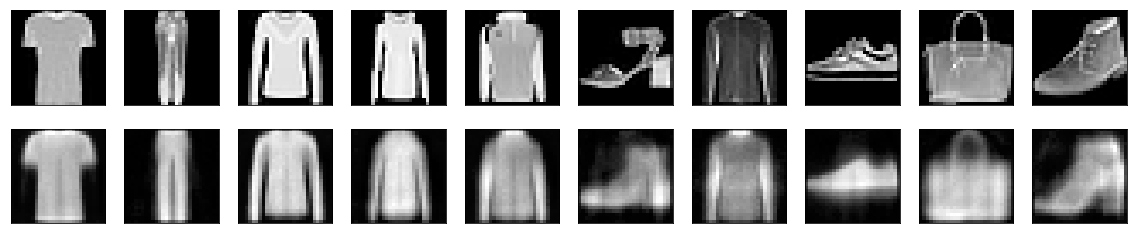

In [9]:
bastien_utils.plot_reconstructions(autoencoder, x_small)

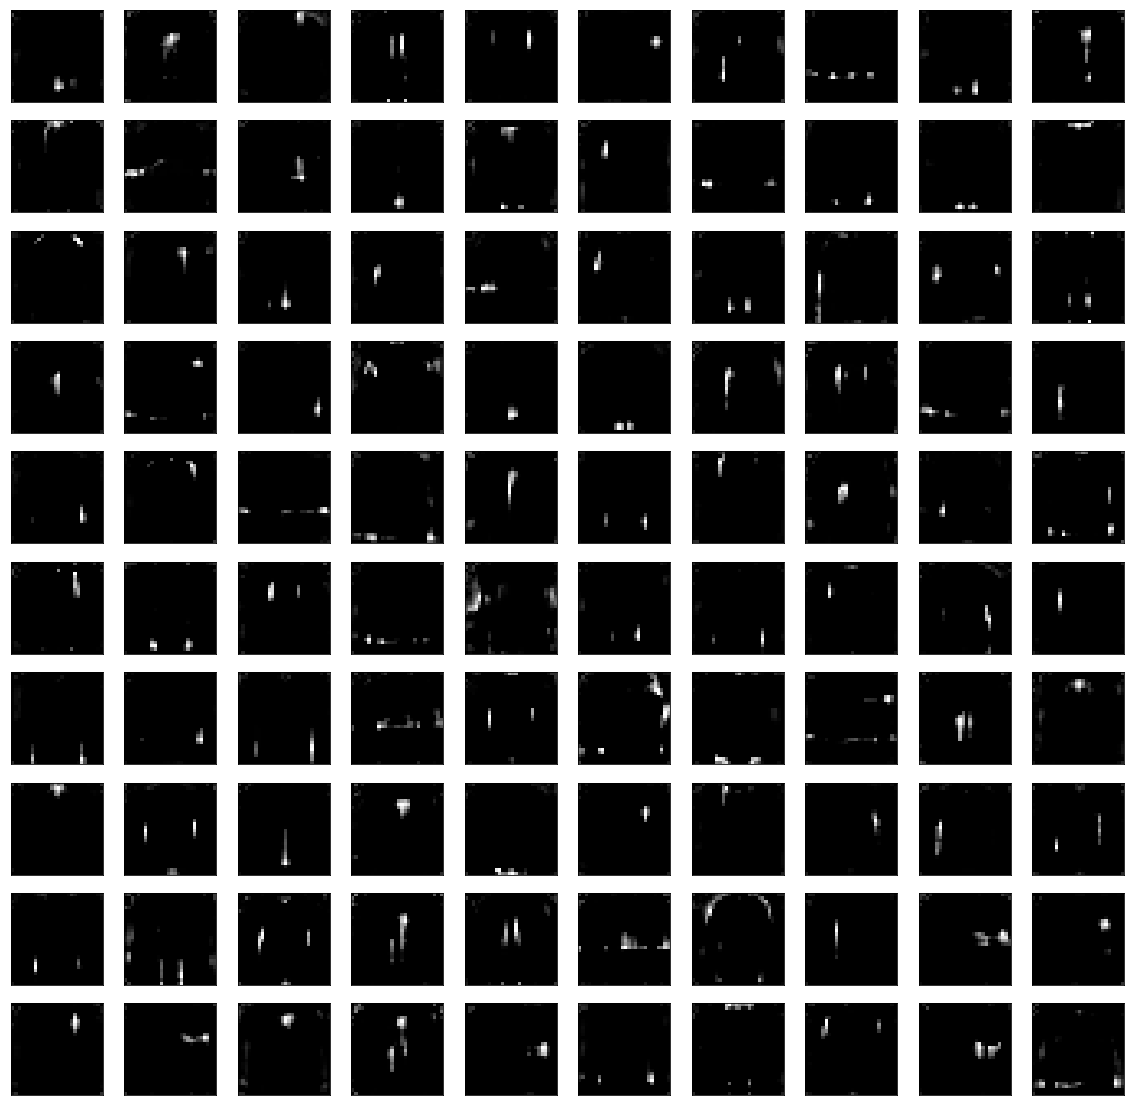

In [10]:
bastien_utils.plot_atoms(encoder)